In [1]:
import torch
from datasets.pascal_voc import create_voc_dataloaders, VOC_CLASSES, VOC_COLORMAP
import matplotlib.pyplot as plt
import numpy as np
import torch
from unet import UNet
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import CrossEntropyLoss
from train import train_one_epoch, validate_batch

In [2]:
base_path = 'data'  # base path of where the Pascal VOC dataset is stored
train_loader, val_loader, test_loader = create_voc_dataloaders(
    base_path=base_path,
    batch_size=16,
    num_workers=4
)


Dataset found at data/pascal-voc


In [3]:
images, masks = next(iter(train_loader))
print(f"Image size: {images.size()}")
print(f"Mask size: {masks.size()}")

Image size: torch.Size([4, 3, 256, 256])
Mask size: torch.Size([4, 256, 256])


In [4]:
# Setup for training
num_classes = len(VOC_CLASSES)  # 21 classes (20 + background)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create color palette dictionary from VOC_COLORMAP
COLOR_PALETTE = {i: tuple(color) for i, color in enumerate(VOC_COLORMAP)}


Pascal VOC Classes and Colors:


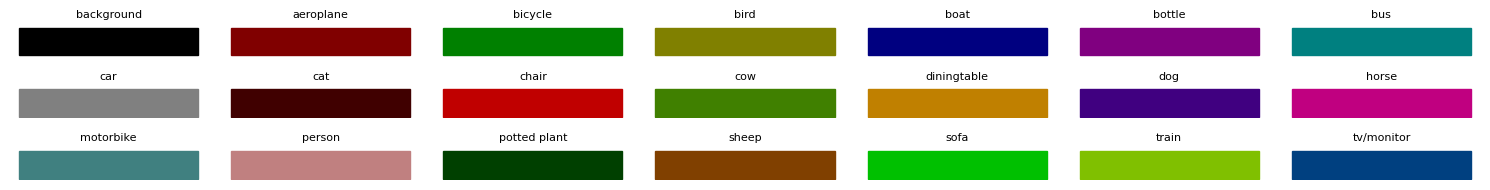


Example Training Samples:


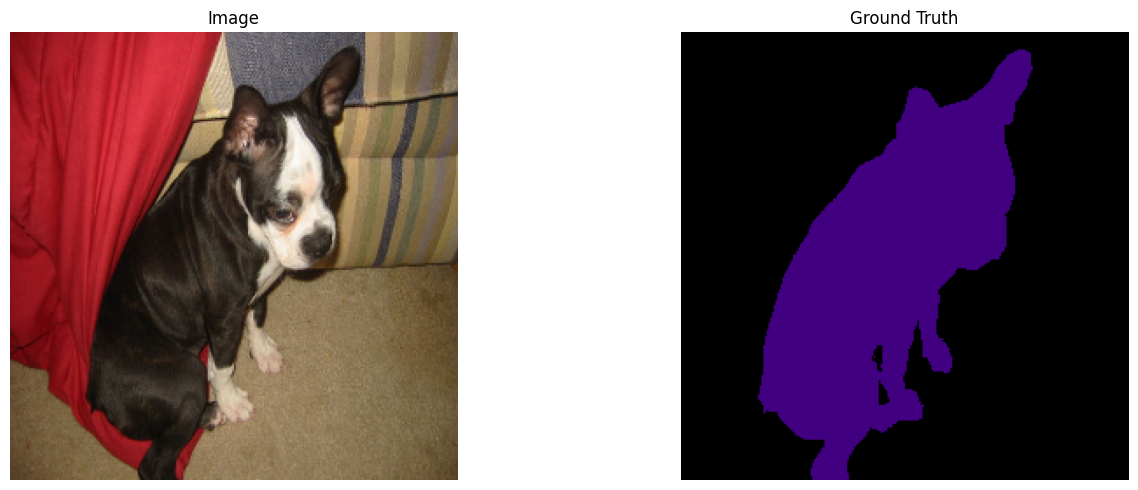

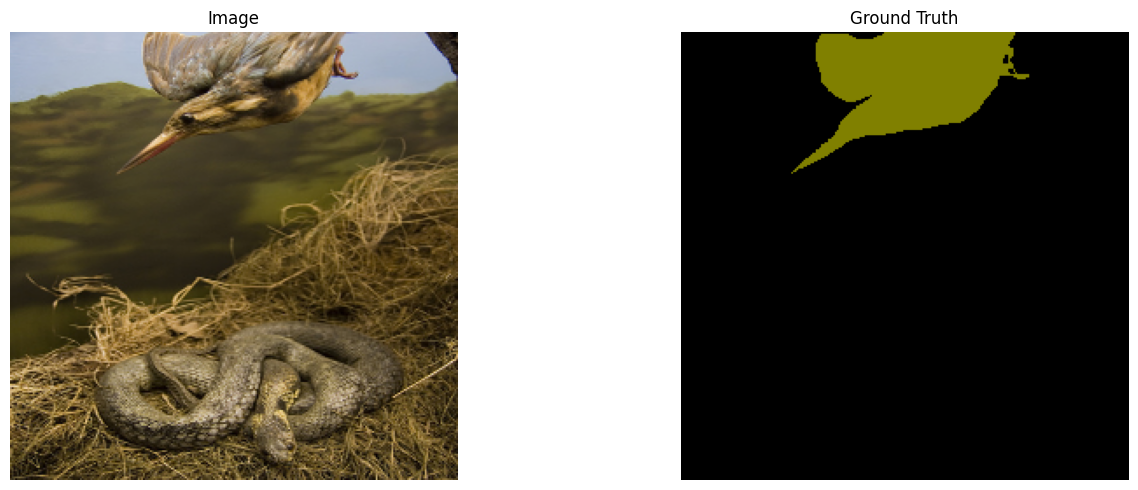

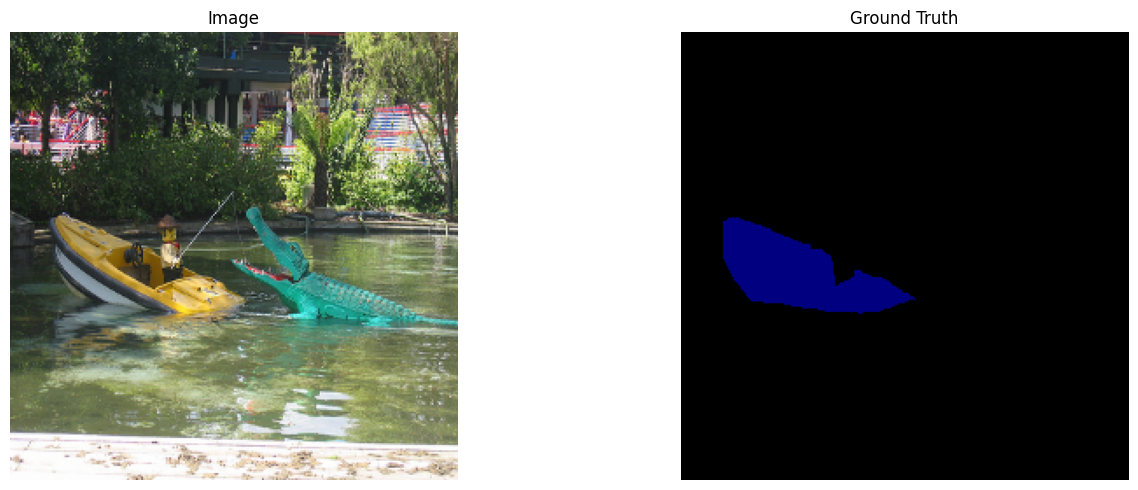

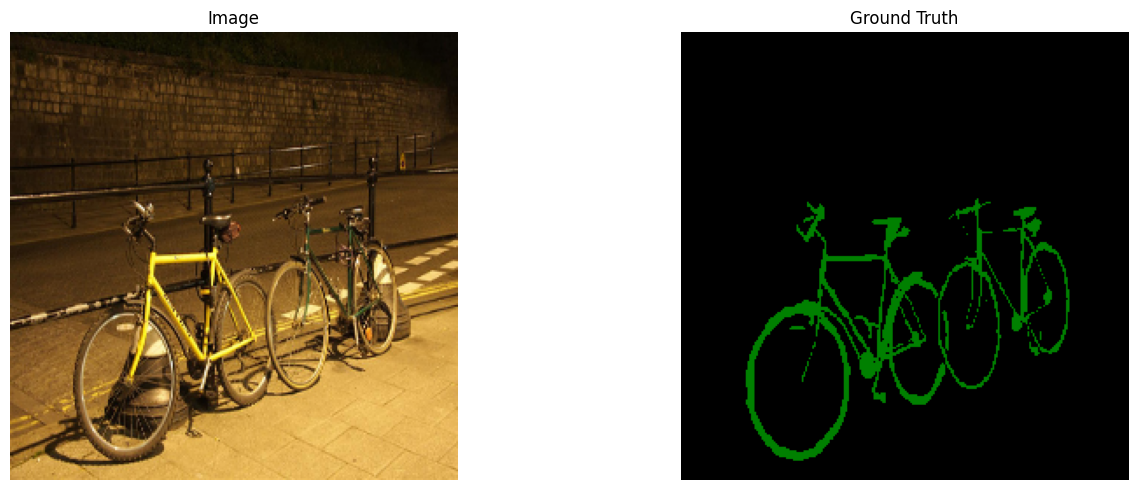

In [5]:
# Function to create a colormap legend
def create_colormap_legend(figsize=(15, 2)):
    """Create a legend showing the Pascal VOC classes and their corresponding colors"""
    n_classes = len(VOC_CLASSES)
    n_cols = 7  # Number of columns in the legend
    n_rows = (n_classes + n_cols - 1) // n_cols  # Calculate required number of rows

    plt.figure(figsize=figsize)
    for i, (class_name, color) in enumerate(zip(VOC_CLASSES, VOC_COLORMAP)):
        row = i // n_cols
        col = i % n_cols

        # Create a small colored rectangle for each class
        plt.subplot(n_rows, n_cols, i + 1)
        plt.fill([0, 1, 1, 0], [0, 0, 1, 1], color=[x/255 for x in color])
        plt.axis('off')
        plt.title(class_name, fontsize=8)

    plt.tight_layout()
    plt.show()

# Function to plot images and masks
def plot_sample(image, mask, prediction=None):
    """
    Plot the image, ground truth mask, and prediction (if provided)
    Args:
        image: Tensor of shape (C, H, W)
        mask: Tensor of shape (H, W)
        prediction: Optional tensor of shape (C, H, W)
    """
    n_subplots = 3 if prediction is not None else 2
    plt.figure(figsize=(15, 5))

    # Plot original image
    plt.subplot(1, n_subplots, 1)
    img = image.permute(1, 2, 0).cpu().numpy()
    # Denormalize image
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Image')

    # Plot ground truth mask
    plt.subplot(1, n_subplots, 2)
    mask_colored = np.zeros((*mask.shape, 3))
    mask_np = mask.cpu().numpy()
    for class_idx, color in enumerate(VOC_COLORMAP):
        mask_colored[mask_np == class_idx] = [x/255 for x in color]
    plt.imshow(mask_colored)
    plt.axis('off')
    plt.title('Ground Truth')

    # Plot prediction if provided
    if prediction is not None:
        plt.subplot(1, n_subplots, 3)
        pred = torch.argmax(prediction, dim=0).cpu().numpy()
        pred_colored = np.zeros((*pred.shape, 3))
        for class_idx, color in enumerate(VOC_COLORMAP):
            pred_colored[pred == class_idx] = [x/255 for x in color]
        plt.imshow(pred_colored)
        plt.axis('off')
        plt.title('Prediction')

    plt.tight_layout()
    plt.show()

# Function to plot batch of samples
def plot_batch_samples(images, masks, predictions=None, num_samples=4):
    """
    Plot a batch of samples
    Args:
        images: Tensor of shape (B, C, H, W)
        masks: Tensor of shape (B, H, W)
        predictions: Optional tensor of shape (B, C, H, W)
        num_samples: Number of samples to plot
    """
    num_samples = min(num_samples, len(images))

    for i in range(num_samples):
        if predictions is not None:
            plot_sample(images[i], masks[i], predictions[i])
        else:
            plot_sample(images[i], masks[i])
        plt.show()

# Display the colormap legend
print("Pascal VOC Classes and Colors:")
create_colormap_legend()

# Get a batch of samples and visualize them
images, masks = next(iter(train_loader))
print("\nExample Training Samples:")
plot_batch_samples(images, masks)

# Example usage during training/validation:
# """
# During training loop:
# with torch.no_grad():
#     val_images, val_masks = next(iter(val_loader))
#     val_images = val_images.to(device)
#     predictions = model(val_images)

#     print("\nValidation Samples with Predictions:")
#     plot_batch_samples(val_images, val_masks, predictions, num_samples=2)
# """

In [6]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

52374

In [7]:
num_classes

21

In [8]:
import torch
from train import validate_batch
torch.cuda.empty_cache()
from early_stopping import EarlyStopping

model = UNet(n_channels=3, n_classes=num_classes, dropout_rate=0.3, use_batchnorm=True).to(device)
criterion = CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    min_lr=1e-6
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.003,
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

In [9]:
# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_iou': [],
    'learning_rates': []
}

# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training phase
    train_loss, train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, device, num_classes)
    print("Running validation")
    # Validation phase
    val_loss, val_metrics = validate_batch(model, val_loader, criterion, device, num_classes)

    # Update learning rate
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)

    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_metrics['iou'])
    history['learning_rates'].append(current_lr)

    # Print metrics
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val IoU: {val_metrics['iou']:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")

    # Print per-class IoU
    print("\nPer-class IoU:")
    for cls_idx, cls_name in enumerate(VOC_CLASSES):
        iou_key = f'class_{cls_idx}_iou'
        if iou_key in val_metrics:
            print(f"{cls_name}: {val_metrics[iou_key]:.4f}")

    # Check early stopping
    if early_stopping(epoch, model, val_loss):
        print(f"\nTraining stopped early at epoch {epoch+1}")
        break

# Save the final model and history
torch.save(model.state_dict(), 'pascal_voc_ce_final_model.pth')
import pickle
with open('pascal_voc_ce_training_history.pkl', 'wb') as f:
    pickle.dump(history, f)


Epoch 1/2


100%|██████████| 366/366 [01:04<00:00,  5.64it/s, loss=1.97, train_dice=0.0638, train_iou=0.0484, train_precision=0.065, train_recall=0.0671, train_f1_score=0.0638]    


Running validation


100%|██████████| 363/363 [00:28<00:00, 12.72it/s, val_loss=2.65, val_iou=0.0723, val_dice=0.0861, val_precision=0.0983, val_recall=0.0952, val_f1_score=0.0861]


Train Loss: 2.3725
Val Loss: 2.0340
Val IoU: 0.0723
Learning Rate: 0.000100

Per-class IoU:
background: 0.7329
aeroplane: 0.0000
bicycle: 0.0000
bird: 0.0000
boat: 0.0000
bottle: 0.0000
bus: 0.0005
car: 0.0024
cat: 0.0015
chair: 0.0000
cow: 0.0000
diningtable: 0.0000
dog: 0.0000
horse: 0.0000
motorbike: 0.0001
person: 0.0869
potted plant: 0.0000
sheep: 0.0000
sofa: 0.0030
train: 0.0077
tv/monitor: 0.0000

Epoch 2/2


100%|██████████| 366/366 [01:04<00:00,  5.65it/s, loss=1.15, train_dice=0.0748, train_iou=0.0661, train_precision=0.124, train_recall=0.0794, train_f1_score=0.0748] 


Running validation


100%|██████████| 363/363 [00:28<00:00, 12.71it/s, val_loss=2.51, val_iou=0.109, val_dice=0.125, val_precision=0.142, val_recall=0.144, val_f1_score=0.125] 


Train Loss: 1.6226
Val Loss: 1.4239
Val IoU: 0.1087
Learning Rate: 0.000100

Per-class IoU:
background: 0.7473
aeroplane: 0.0000
bicycle: 0.0000
bird: 0.0000
boat: 0.0000
bottle: 0.0000
bus: 0.0041
car: 0.0011
cat: 0.0000
chair: 0.0000
cow: 0.0000
diningtable: 0.0000
dog: 0.0000
horse: 0.0000
motorbike: 0.0009
person: 0.0158
potted plant: 0.0000
sheep: 0.0000
sofa: 0.0000
train: 0.0000
tv/monitor: 0.0000


/tmp/ipykernel_690/711597469.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('pascal_voc_ce_final_model.pth'))


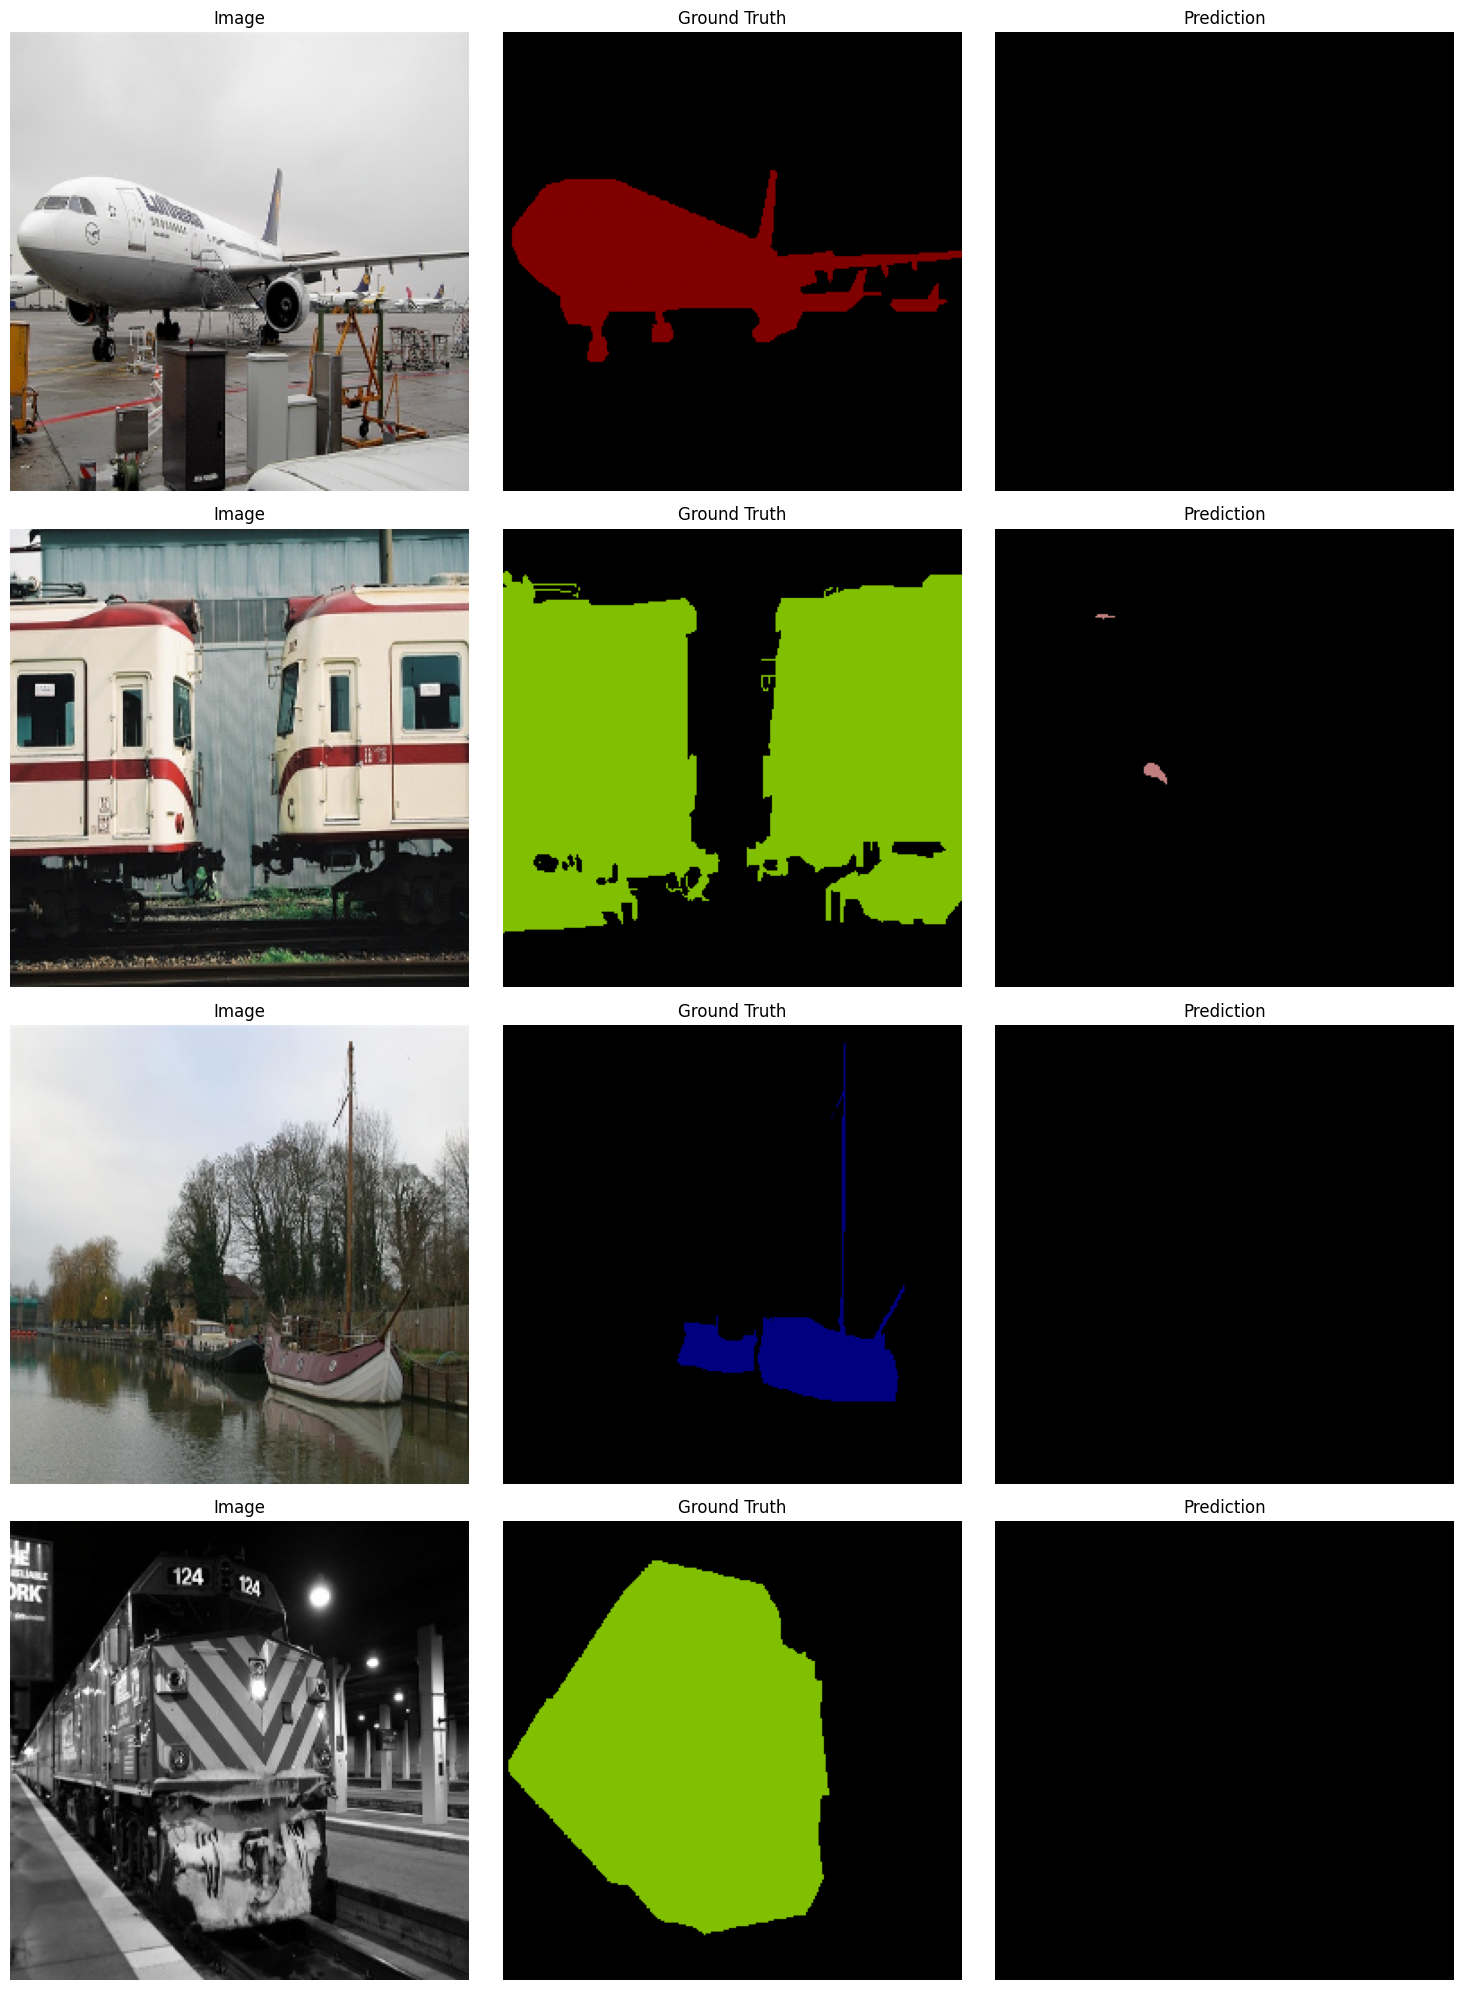

100%|██████████| 363/363 [00:28<00:00, 12.86it/s, val_loss=2.51, val_iou=0.109, val_dice=0.125, val_precision=0.142, val_recall=0.144, val_f1_score=0.125] 



Test Set Metrics:
Loss: 1.4239
IoU: 0.1087
Dice Score: 0.1246
Precision: 0.1418
Recall: 0.1437
F1 Score: 0.1246

Per-class IoU scores:
background: 0.7473
aeroplane: 0.0000
bicycle: 0.0000
bird: 0.0000
boat: 0.0000
bottle: 0.0000
bus: 0.0041
car: 0.0011
cat: 0.0000
chair: 0.0000
cow: 0.0000
diningtable: 0.0000
dog: 0.0000
horse: 0.0000
motorbike: 0.0009
person: 0.0158
potted plant: 0.0000
sheep: 0.0000
sofa: 0.0000
train: 0.0000
tv/monitor: 0.0000


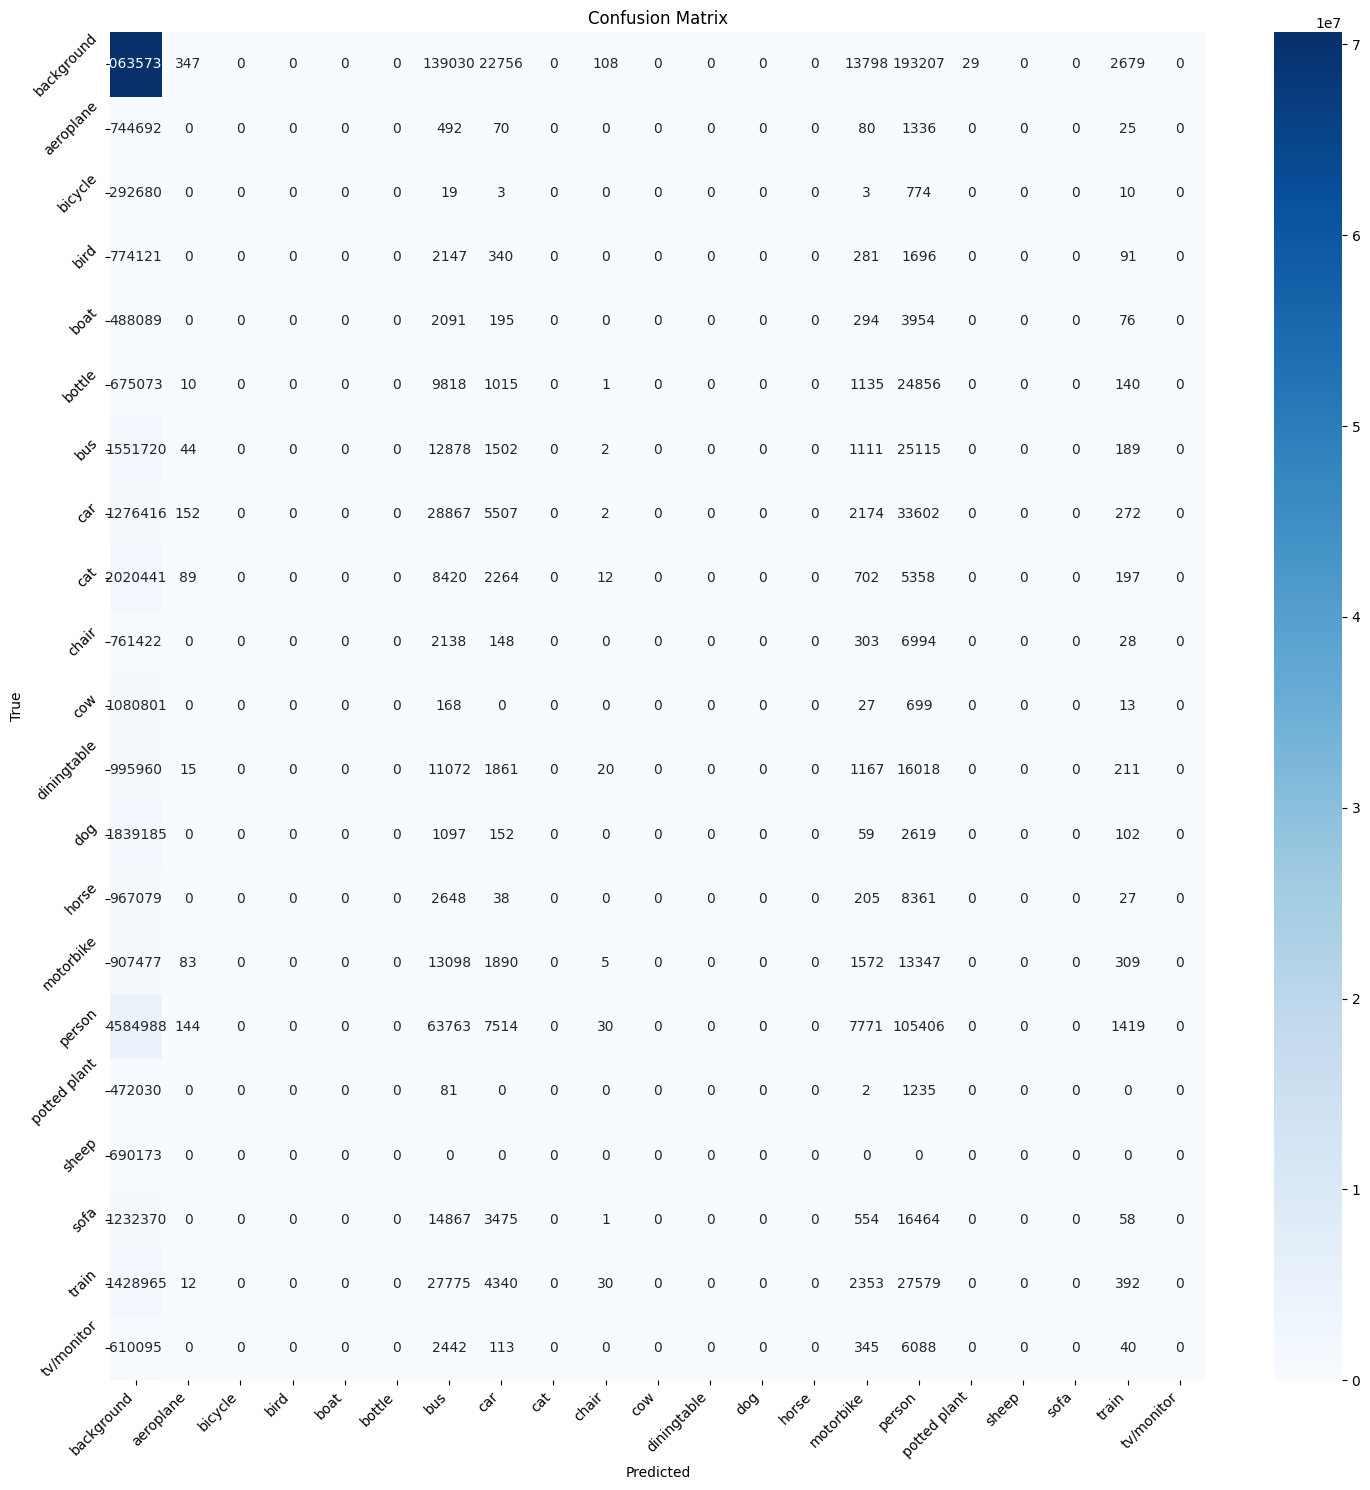


Pascal VOC Classes and Colors:


In [10]:
# Load the best model and run predictions
import torch
from unet import UNet
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import CrossEntropyLoss

def plot_predictions(images, masks, predictions, n_samples=4):
    """
    Plot images, ground truth masks, and predicted masks side by side
    Args:
        images: Tensor of shape (B, C, H, W)
        masks: Tensor of shape (B, H, W)
        predictions: Tensor of shape (B, C, H, W)
        n_samples: Number of samples to display
    """
    # Get predictions
    pred_masks = torch.argmax(predictions, dim=1)

    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5*n_samples))

    for i in range(n_samples):
        # Plot original image
        img = images[i].permute(1, 2, 0).cpu().numpy()
        # Denormalize image
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image')

        # Plot ground truth mask
        mask = masks[i].cpu().numpy()
        mask_colored = np.zeros((*mask.shape, 3))
        for class_idx, color in enumerate(VOC_COLORMAP):
            mask_colored[mask == class_idx] = [x/255 for x in color]
        axes[i, 1].imshow(mask_colored)
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Ground Truth')

        # Plot predicted mask
        pred_mask = pred_masks[i].cpu().numpy()
        pred_colored = np.zeros((*pred_mask.shape, 3))
        for class_idx, color in enumerate(VOC_COLORMAP):
            pred_colored[pred_mask == class_idx] = [x/255 for x in color]
        axes[i, 2].imshow(pred_colored)
        axes[i, 2].axis('off')
        axes[i, 2].set_title('Prediction')

    plt.tight_layout()
    plt.show()

def get_batch_predictions(model, data_loader, num_batches=1):
    """
    Get predictions for a few batches from the data loader
    """
    model.eval()
    all_images = []
    all_masks = []
    all_predictions = []

    with torch.no_grad():
        for i, (images, masks) in enumerate(data_loader):
            if i >= num_batches:
                break

            images = images.to(device)
            predictions = model(images)

            all_images.append(images)
            all_masks.append(masks)
            all_predictions.append(predictions)

    return (torch.cat(all_images, 0),
            torch.cat(all_masks, 0),
            torch.cat(all_predictions, 0))

# Load the best model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = len(VOC_CLASSES)  # 21 classes (20 + background)
loaded_model = UNet(n_channels=3, n_classes=num_classes).to(device)
loaded_model.load_state_dict(torch.load('pascal_voc_ce_final_model.pth'))
loaded_model.eval()

# Get predictions for a few test batches
test_images, test_masks, test_predictions = get_batch_predictions(loaded_model, test_loader, num_batches=1)

# Plot the results
plot_predictions(test_images, test_masks, test_predictions, n_samples=4)

# Calculate and print metrics for the test set
criterion = CrossEntropyLoss()
test_loss, test_metrics = validate_batch(loaded_model, test_loader, criterion, device, num_classes)
print("\nTest Set Metrics:")
print(f"Loss: {test_loss:.4f}")
print(f"IoU: {test_metrics['iou']:.4f}")
print(f"Dice Score: {test_metrics['dice']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1_score']:.4f}")

# Print per-class IoU scores
print("\nPer-class IoU scores:")
for class_idx, class_name in enumerate(VOC_CLASSES):
    iou_key = f'class_{class_idx}_iou'
    if iou_key in test_metrics:
        print(f"{class_name}: {test_metrics[iou_key]:.4f}")

# Optional: Create a confusion matrix visualization
import seaborn as sns

def plot_confusion_matrix(metrics):
    plt.figure(figsize=(15, 15))
    conf_matrix = metrics['confusion_matrix']

    # Convert confusion matrix to integers if necessary
    conf_matrix = conf_matrix.astype(int)

    # Create labels for classes
    labels = VOC_CLASSES

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(test_metrics)

# Create legend for class colors
print("\nPascal VOC Classes and Colors:")